<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_ImageClassificatioin_02_multi_labael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI・機械学習 勉強会 #2
## - オリジナル画像による画像分類モデルの構築 -


## 目次

  
2.1.   概要

2.2.   実装プロセス

1.   画像データの収集
2.   環境準備
3.   学習に向けたデータの準備
4.   モデル構築
5.   モデルの学習
6.   モデルによる予測
7.    特徴の可視化
8.   モデルのファイル出力
9.   TensorBoardでの確認









---



##2.1 概要
「TensorFlow_Keras_ImageClassification_01」をベースとして、自分で収集した画像ファイルを用いて画像分類モデルを構築します。





---



## 2.2 実装プロセス

画像データの準備は本ノートブック上では行えませんので、各自のPCにて実施します。

MNISTやCIFAR10などの公開されているデータセットではなく、自ら収集したオリジナルデータセットを用いて学習を行います。

オリジナルのデータセットの作成およびそれを用いた学習の参考としてください。

データ準備以降のステップについては、「TensorFlow_Keras_ImageClassification_01」と基本的には同じです。


###2.2.1 画像データの収集

まずは、画像分類を行いたい画像を集めましょう。Webからスクレイピングするのも良し、自分で写真を撮って集めるのも良いです。

Deep Learningにおいては、データの量が重要だと良く言われます。

ただ、大量のデータといっても、品質が伴っていないと意味がありません。

たとえば、判断不能なデータをラベリングし、学習させてしまっては、間違いを教えていることと同義になってしまいます。

また、データは大量に用意できても、バリエーションに乏しければ、モデルの汎化性能は高くなりません。

どのような画像が使えるのか、使えないのか、を知ることも精度の高いモデル構築に必要な知識です。

かなり地味な作業となりますが、是非トライしてみてください。


スクレイピングの方法はいくらでもありますが、Python使いであれば、下記が使いやすいので紹介しておきます。

[Google Image Download](https://google-images-download.readthedocs.io/en/latest/index.html)

こちらは[GitHub](https://github.com/hardikvasa/google-images-download)でソースも公開されています。

Googleの画像検索から、指定したキーワードの結果を取得してくれます。

本ノートブックで使うサンプルもこちらを用いて収集しました。


本ノートブックでは、4クラス分類、64 x 64 のカラーの各クラス40枚(合計120枚)のサンプル画像をもとにソースコードを記載しています。

各自準備したデータに応じて実装内容を調整してください。

※サンプルデータでは、すべてのファイルを64 x 64に調整済みですが、コーディングにてreshapeする形でも問題ありません。


In [0]:
# 分類クラス数
num_classes = 4

# クラス毎の画像ファイル数
num_images = 40

# 画像のサイズ
height, width, color = 64, 64, 3

### 2.2.2 環境準備

モデル構造は、前回のノートブックと同様のシンプルなCNN、VGG16、RESNETv1/v2を用意しています。

自力でデータ収集するとなると、それほど多くの画像ファイルは期待できないと思います。

少量のデータの場合に、モデル構造によってどのような違いが出るのか比較するもの良いかと思います。


In [0]:
# モデル構造を指定 (CNN, VGG16, RESNET1 or RESNET2)
model_opt="VGG16"

Google Colabratoryは、ランタイムが初期化されるとデータも失われます。

学習した中のチェックポイントが学習済みモデルを再利用できるよう、Google Driveをマウントし、ここに出力できるようしておきましょう。

In [3]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')
gdrive_base='/content/drive/My Drive/Colab Notebooks/'

# TensorBorad用ログ
log_dir=gdrive_base+'ImageClassification/logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# チェックポイントおよび学習済みモデルファイル
model_dir=gdrive_base+'ImageClassification/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 2.2.3 学習に向けたデータの準備





収集した画像データをアップロードし、学習に使えるデータに変換していきます。

全データを格納するための空のテンソルを準備します。

テンソルは以下の５要素になります。

- クラス番号(0～)
- クラスごとのファイル番号(0～)
- 画像のHeight
- 画像のWidth
- 画像のRBG

In [0]:
import numpy as np
import os
import cv2
from glob import glob

# 空のテンソルを用意
ary = np.zeros([num_classes, num_images, height, width, color], dtype=np.int)

画像ファイルをGoogle Colabにアップロードし、１枚ずつ読み込み、テンソルに格納していきます。

サンプルデータでは、ファイル名にてクラスを判別し、テンソルの１要素目(=クラス)を指定し、データを格納させています。

Numpyには、テンソルデータを保存させておく機能があります。

savez_compressed関数を使用し、作成したテンソルデータを再利用可能なようにファイル出力しておきましょう。

In [5]:
# 学習データのアップロード
# ここではサンプルデータをGitHubから取得していますが、適宜zip形式などでGoogle Colabにアップロードしてください。
!wget -nc https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/gface64x64.zip
!unzip -oq gface64x64.zip

dir_name='gface64x64'

c0=0 # rx-178:mk2
c1=0 # msz-006:Z
c2=0 # rx-93:Nu
c3=0 # ms-06:Zaku

# 画像を順次読み込み、テンソルデータに変換
for file in glob(dir_name + '/*.jpg'):
    img = cv2.imread(file,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if 'rx-178' in file:
        ary[0, c0] = img
        c0 += 1
    elif 'msz-006' in file:
        ary[1, c1] = img
        c1 += 1
    elif 'rx-93' in file:
        ary[2, c2] = img
        c2 += 1
    elif 'ms-06' in file:
        ary[3, c3] = img
        c3 += 1

np.savez_compressed('gface_images.npz', ary)

--2019-07-24 07:28:06--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/gface64x64.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504181 (492K) [application/zip]
Saving to: ‘gface64x64.zip’

gface64x64.zip      100%[===================>] 492.36K  --.-KB/s    in 0.1s    

2019-07-24 07:28:07 (3.91 MB/s) - ‘gface64x64.zip’ saved [504181/504181]



ここまでで、収集データを１つのテンソルに纏めることができました。

次に、このテンソルをもとに、画像データ用テンソルと、ラベル用テンソルを作成します。



In [0]:
#保存したnpzファイルはnp.loadにて読み込むことができます
#ary = np.load("gface_images.npz")['arr_0']

# 画像データのテンソルをソートし、ラベル用テンソルを用意
X_train = np.zeros([num_classes * num_images, height, width, color], dtype=np.int)
for i in range(num_classes):
    for j in range(num_images):
        X_train[(i * num_images) + j] = ary[i][j]

# X_trainはクラス番号でソートされて格納されているので、下記だけでラベルデータが生成できる
Y_train = np.repeat(np.arange(num_classes), num_images)

Deep Learningには、学習データと検証データの２種類のデータが必要です。

sklearnには、データを指定の割合で分割してくれる関数があります。これを利用して学習データと検証データに分割します。


In [7]:
from sklearn.model_selection import train_test_split

# 検証データの割合を指定
validate_rate=0.2

# 学習データと検証データに分割
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=validate_rate)

print(x_train.shape)
print(x_test.shape)

(128, 64, 64, 3)
(32, 64, 64, 3)


今回はもう一つ、ラベルを追加し、1つのインプット画像から、2つアウトプット(ラベル)を出力するネットワークとしてみます。

In [0]:
import copy

# 全体のラベルから複製して構成
def add_label(y):
    y2 = copy.deepcopy(y)
    for i in range(len(y)):
        # Gundam
        if y2[i] in [0,1,2]:
            y2[i] = 0
        # Zeon
        else:
            y2[i] = 1
    return y2

num_classes2 = 2
y_train2 = add_label(y_train)
y_test2 = add_label(y_test)


学習用画像データと画像に対応したラベルを表示してみます。

画像表示には、matplotlibライブラリを用います。これはPythonにてグラフ表示によく使われるライブラリなので、使用方法は覚えておくと良いです。

参考：https://matplotlib.org/api/pyplot_api.html


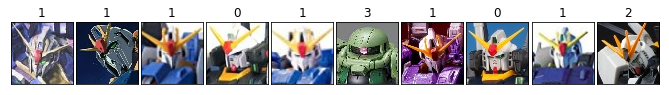

In [9]:
#jupyter notebook用マジックコマンド
%matplotlib inline 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

ラベルデータをone-hot表現に変換します。

keras.utils.to_categorical関数を使いましょう。


In [0]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# ラベルデータをone-hot表現へ変換
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 追加ラベルも同じく変換
y_train2 = to_categorical(y_train2, num_classes2)
y_test2 = to_categorical(y_test2, num_classes2)

In [0]:
# 画像データの型を変換
x_train = x_train.reshape(-1, height, width, color).astype(np.float32)
x_test = x_test.reshape(-1, height, width, color).astype(np.float32)
input_shape = (height, width, color)

### 2.2.4 モデル構築

これから、学習モデルを構築します。

モデルの構築は、モデルの「容器」としてSquential()を実施したのち、その中に順にレイヤーを追加していく流れになります。

* [Sequential](https://keras.io/ja/models/sequential/)


In [0]:
# モデル構築用ライブラリをインポート
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten

# CNNモデル用ライブラリ
from tensorflow.python.keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D,AveragePooling2D,Input
from tensorflow.python.keras import initializers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2

# モデルの「容器」を作成
model = Sequential()

今回は、シンプルなCNNモデルの他、VGG16、RESNETの関数を準備してあります。

- VGG16

    Oxford大学の研究グループが提案し2014年のILSVRで2位を獲得したモデルで、畳み込みが13層、全結合層が3層の合計16層からなるニューラルネットワークです。
    Kerasでは関数として組み込まれており、容易に実装することが可能になっています。
    
- ResNet

    ResNetは2015年にMicrosoftより発表された152層からなるニューラルネットワークです。今まで20層ほどで作られていたCNNを特別なユニットを挟むことで深くすることを可能にしています。


In [0]:
# VGG16モデル
def cnn_vgg16():

    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)    

    x = vgg16.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)

    # original labels, 0 to 9, as output1
    output1 = Dense(num_classes, activation='softmax', name='output1')(x)
    # second labels, 0 or 1, as output2
    output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
    
    # Instantiate model.
    model = Model(inputs=input_tensor, outputs=[output1, output2])

    #fix weights VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = False
        
    return model    


In [0]:
# CNNモデル w/Batch Normalization
def cnn_w_batchnorm():

    inputs = Input(shape=input_shape)
    x = inputs

    x = Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros())(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros())(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
               
    x = Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros())(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), kernel_initializer=initializers.TruncatedNormal(stddev=0.1), bias_initializer=initializers.Zeros())(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)

    # original labels, 0 to 9, as output1
    output1 = Dense(num_classes, activation='softmax', name='output1')(x)
    # second labels, 0 or 1, as output2
    output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=[output1, output2])
    return model    
     

In [0]:
# ResNetモデル from Keras Documentation

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
#if version == 1:
#    depth = n * 6 + 2
#elif version == 2:
#    depth = n * 9 + 2

# ResNetモデル
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth=20, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
#    y = Flatten()(x)
#    outputs = Dense(num_classes,
#                    activation='softmax',
#                    kernel_initializer='he_normal')(y)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
#    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # original labels, 0 to 9, as output1
    output1 = Dense(num_classes, activation='softmax', name='output1')(x)
    # second labels, 0 or 1, as output2
    output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=[output1, output2])
    return model



def resnet_v2(input_shape, depth=29, num_classes=num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
#    y = Flatten()(x)
#    outputs = Dense(num_classes,
#                    activation='softmax',
#                    kernel_initializer='he_normal')(y)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
#    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # original labels, 0 to 9, as output1
    output1 = Dense(num_classes, activation='softmax', name='output1')(x)
    # second labels, 0 or 1, as output2
    output2 = Dense(num_classes2, activation='softmax', name='output2')(x)
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=[output1, output2])
    return model


それでは、任意のモデルを選び、構築してみましょう。

In [16]:
# model構築
if model_opt=="VGG16":
    model = cnn_vgg16()
elif model_opt=="RESNET1":
    model = resnet_v1(input_shape=input_shape)
elif model_opt=="RESNET2":
    model = resnet_v2(input_shape=input_shape)
else:
    model=cnn_w_batchnorm()


W0724 07:28:13.567831 140146061514624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


58892288/58889256 [==============================] - 6s 0us/step


学習の開始にあたり、最後にcompile関数でコンパイルを行います。

compile関数でも、学習にあたって以下のパラメータを指定する必要があります。

* optimizer（最適化手法）
* loss（損失関数）
* metrics（評価関数（任意））

以下サンプルコードでは、現在Kerasで利用できるoptimizerを並べてみました。こちらもそれぞれどのような結果になるか比較してみるといいでしょう。

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
# モデルの学習方法について指定しておく
model.compile(loss={'output1': 'categorical_crossentropy','output2': 'categorical_crossentropy'}, optimizer=optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adamax(lr=0.001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=0.001), metrics=['accuracy'])


Optimizerアルゴリズムの動作イメージ(作者：Alec Radford)


<img src="http://sebastianruder.com/content/images/2016/01/contours_evaluation_optimizers.gif" width="400">
<img src="http://sebastianruder.com/content/images/2016/01/saddle_point_evaluation_optimizers.gif" width="400">


早速学習開始と行きたいところですが、学習の途中結果を記録する(Checkpoint)ことと、TensorBoard向けのログ情報を取得できるようにしておきましょう。

モデル構造や結果等の視覚化することで、何がどのように動いているのか、理解の手助けとなります。

このjupyter notebook上でも可視化ロジックを組み込んでいますが、通常のモデル開発においては、TensorBoardを用いるほうがスマートでしょう。


TensorBoardでも参照できるよう、設定を組み込んでおきます。

In [0]:
# TensorBoardでの可視化のため、出力先の設定
from tensorflow.keras import callbacks

tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,write_images=1)

チェックポイントを生成しておくことで、中断した学習の再開や、チェックポイントを利用した静的モデルの出力を行うことができます。

In [19]:
# チェックポイント出力先
RUN = RUN + 1 if 'RUN' in locals() else 1
checkpoint_path = model_dir + f'run{RUN}/' + model_opt + "_cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_cb = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=5)

W0724 07:28:24.864158 140146061514624 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


学習の実行の前に、モデルのサマリ情報を確認してみましょう。

In [20]:
# モデルのサマリ情報の表示
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

学習途上のチェックポイントから再開させることもできます。

load_weights関数にてチェックポイントファイルから重みをロードします。

In [0]:
# チェックポイントから学習済みパラメータを復元
#model.load_weights(f'{model_dir}run1/{model_structure}_{data_set}_cp-0010.ckpt')

### 1.2.4 モデルの学習

ようやく学習に入ります。今回は少ない画像データを水増しして学習させる方法を使います。

水増しとは聞こえが悪いですが、画像データに若干の加工を行い、データのバリエーションを増やすことが目的です。

この場合、学習処理にはfit_generator関数を使います。

Kerasに実装されているImageDataGenerator関数を用いる他、自分でgeneratorを実装することもできます。

ImageDataGeneratorでは以下のようなパラメータを使用することができます。

- rotation_range：画像を指定のレンジの幅で傾ける
- zoom_range：画像の指定のレンジの幅で拡大する
- height_shift_range：画像を指定のレンジの幅で縦にスライドする
- width_shift_range：画像を指定のレンジの幅で横にスライドする

今回は、自作のgenerator関数を用意しました。


In [22]:
from keras.preprocessing import image
from random import shuffle
from scipy import ndimage

def generator(x, y1, y2, train):
    batch_size = 16

    while True:
        if train:
            keys = list(range(len(x)))
            shuffle(keys)
        else:
            keys = list(range(len(y1)))
            shuffle(keys)
        inputs = []
        label1 = []
        label2 = []

        for key in keys:
            img = x[key]
            if train:
                # 画像の回転
                rotate_rate = np.random.normal(0,0.5)*10
                img = ndimage.rotate(x[key], rotate_rate)
                img = cv2.resize(img,(height,width))
                # 画像のぼかし
                if np.random.randint(0,2):
                    filter_rate = np.random.randint(0,6)
                    img = ndimage.gaussian_filter(img, sigma=filter_rate)

            inputs.append(img)
            label1.append(y1[key])
            label2.append(y2[key])

            if len(inputs) == batch_size:
                tmp_inputs = np.array(inputs)
                tmp_label1 = np.array(label1)
                tmp_label2 = np.array(label2)
                inputs = []
                label1 = []
                label2 = []
                yield tmp_inputs, {'output1': tmp_label1, 'output2': tmp_label2}


Using TensorFlow backend.


In [23]:
# epoch数を指定
epochs=10

# batchサイズを指定
batch_size=500

# 学習の実行(fit)
#result = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=[tb_cb, cp_cb], validation_data=(x_test, y_test))

    
# 学習の実行 (fit_generator)
result = model.fit_generator(generator(x_train, y_train, y_train2, True),
                             steps_per_epoch=x_train.shape[0], 
                             epochs=epochs, 
                             validation_data=generator(x_test, y_test, y_test2, False), 
                             validation_steps=2, 
                             verbose=1,
                             callbacks=[tb_cb])


Epoch 1/10
  1/128 [..............................] - ETA: 8:33 - loss: 4.0396 - output1_loss: 2.6773 - output2_loss: 1.3623 - output1_acc: 0.2500 - output2_acc: 0.3125

W0724 07:28:30.802888 140146061514624 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.460649). Check your callbacks.


  2/128 [..............................] - ETA: 5:00 - loss: 3.3163 - output1_loss: 2.2780 - output2_loss: 1.0383 - output1_acc: 0.2500 - output2_acc: 0.4688

W0724 07:28:30.854873 140146061514624 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.247199). Check your callbacks.


  3/128 [..............................] - ETA: 3:20 - loss: 3.0883 - output1_loss: 2.1299 - output2_loss: 0.9584 - output1_acc: 0.2083 - output2_acc: 0.4583

W0724 07:28:30.901086 140146061514624 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.123623). Check your callbacks.


128/128 [==============================] - 16s 123ms/step - loss: 0.7872 - output1_loss: 0.5474 - output2_loss: 0.2398 - output1_acc: 0.7861 - output2_acc: 0.8950 - val_loss: 0.5204 - val_output1_loss: 0.4567 - val_output2_loss: 0.0637 - val_output1_acc: 0.8750 - val_output2_acc: 0.9688
Epoch 2/10
128/128 [==============================] - 11s 84ms/step - loss: 0.4144 - output1_loss: 0.2820 - output2_loss: 0.1324 - output1_acc: 0.8984 - output2_acc: 0.9497 - val_loss: 0.7119 - val_output1_loss: 0.6238 - val_output2_loss: 0.0880 - val_output1_acc: 0.8750 - val_output2_acc: 1.0000
Epoch 3/10
128/128 [==============================] - 11s 84ms/step - loss: 0.2993 - output1_loss: 0.2034 - output2_loss: 0.0959 - output1_acc: 0.9351 - output2_acc: 0.9697 - val_loss: 0.5883 - val_output1_loss: 0.4708 - val_output2_loss: 0.1175 - val_output1_acc: 0.8750 - val_output2_acc: 0.9688
Epoch 4/10
128/128 [==============================] - 11s 83ms/step - loss: 0.2618 - output1_loss: 0.1901 - output2_

学習結果の評価については、evaluate関数にて得ることができます。

主な引数は次の通りです。

* x：評価に使用する入力データ
* y：評価に使用する出力データ
* batch_size：1回の評価を行うにあたって用いるサンプル数
* verbose：評価のログを出力するか（0:しない、1：する(デフォルト)）

基本的には、損失(Loss)は低ければ低いほうが、評価(Accuracy)は高ければ高いほうが良いです。

Accuracyはモデルの精度そのもの、Lossは学習が効率よく行われているかを示す指標で、Lossが高いまま収束していかない＝効率が良くなく、モデル構造やパラメータ改善の余地あり、という感覚でよいかと思います。


In [24]:
#score = model.evaluate(x_test, y_test, verbose=0)
score = model.evaluate(x_test, {'output1': y_test,'output2': y_test2}, verbose=0)
print('Label#1 Test loss:', score[1])
print('Label#1 Test accuracy:', score[3])

print('Label#2 Test loss:', score[2])
print('Label#2 Test accuracy:', score[4])

Label#1 Test loss: 0.5269705
Label#1 Test accuracy: 0.90625
Label#2 Test loss: 0.03419111
Label#2 Test accuracy: 1.0


epochごとのAccuracyおよびLossの遷移をグラフ化してみましょう。

fit関数のreturnから、データを取得することができます。

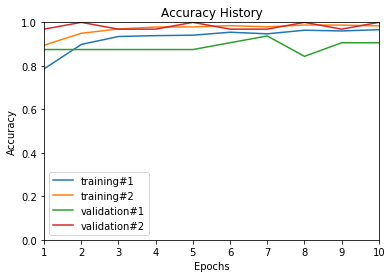

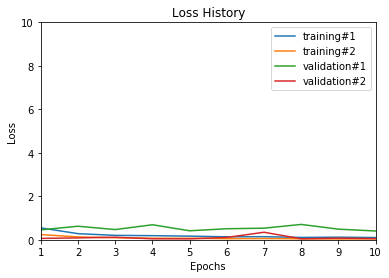

<Figure size 432x288 with 0 Axes>

In [25]:
result.history.keys() # ヒストリデータのラベルを見てみる

plt.plot(range(1, epochs+1), result.history['output1_acc'], label="training#1")
plt.plot(range(1, epochs+1), result.history['output2_acc'], label="training#2")
plt.plot(range(1, epochs+1), result.history['val_output1_acc'], label="validation#1")
plt.plot(range(1, epochs+1), result.history['val_output2_acc'], label="validation#2")
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,1])
plt.show()
plt.savefig(model_opt+'_'+'acc.png')

plt.plot(range(1, epochs+1), result.history['output1_loss'], label="training#1")
plt.plot(range(1, epochs+1), result.history['output2_loss'], label="training#2")
plt.plot(range(1, epochs+1), result.history['val_output1_loss'], label="validation#1")
plt.plot(range(1, epochs+1), result.history['val_output2_loss'], label="validation#2")
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim([1,epochs])
plt.ylim([0,10])
plt.show()
plt.savefig(model_opt+'_'+'loss.png')

### 2.2.6 モデルによる予測

精度だけ見ても面白くないので、検証用データの予測結果を見てみましょう。

Sequential.predict関数によって予測を行うことができます。

主な引数は次の通りです。

* x_test：予測に使用する入力データ
* batch_size：まとめて1度に予測を行うサンプル数
* verbose：評価のログを出力するか（0:しない(デフォルト)、1：する）

In [26]:
classes = model.predict(x_test, batch_size=128, verbose=1)

32/32 [==============================] - 0s 3ms/sample


上記コマンドで検証用データの予測を実施しています。

どのような結果が得られているかイメージしやすくするために、画像を1枚抽出して、その結果を実際に見てみます。


ラベル#1の確からしさ(%)：[99.  0.  1.  0.]
推論結果：rx-178
ラベル#2の確からしさ(%)：[98.  2.]
推論結果：EFF


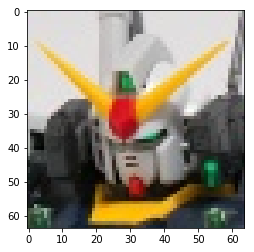

In [27]:
# データセットの推論結果と元画像を確認
# test_numを0～9999で指定してください
%matplotlib inline
test_num=1
test_img = np.squeeze(x_test[test_num])

#labels = np.array([0,1,2,3,4,5,6,7,8,9])
labels1 = np.array([
        'rx-178',
        'msz-006',
        'rx-93',
        'ms-06'])

labels2 = np.array([
        'EFF',
        'Zeon'])

print("ラベル#1の確からしさ(%)："+str(np.round(classes[0][test_num],decimals=2)*100))
print("推論結果："+str(labels1[classes[0][test_num].argmax()]))

print("ラベル#2の確からしさ(%)："+str(np.round(classes[1][test_num],decimals=2)*100))
print("推論結果："+str(labels2[classes[1][test_num].argmax()]))

plt.imshow(test_img.astype(np.int),'gray')
plt.show()

予測精度の最終確認として、Confusion Matrixを表示してみます。

X軸とY軸が一致する箇所に集中していれば(要するに左上から右下に斜めに赤くなっている)、精度の良いモデルと言えるでしょう。

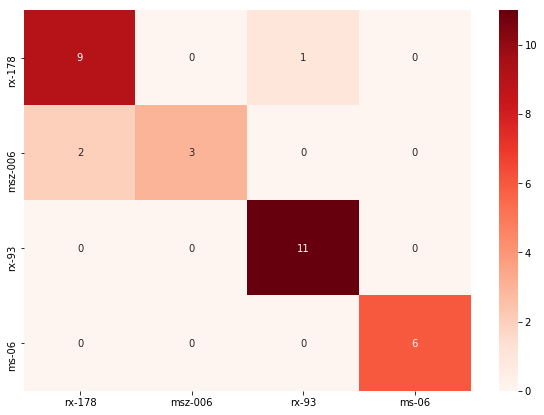

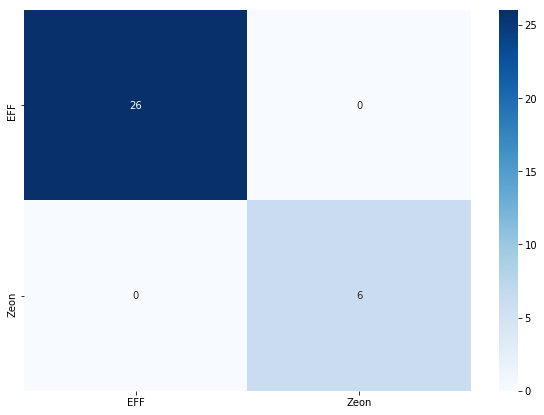

In [28]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# ラベル#1のマトリックス
cmatrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(classes[0], 1))
cmatrix_plt = pd.DataFrame(cmatrix, index=labels1, columns=labels1)

plt.figure(figsize = (10,7))
sns.heatmap(cmatrix_plt, annot=True, cmap="Reds", fmt="d")
plt.show()

# ラベル#2のマトリックス
cmatrix = confusion_matrix(np.argmax(y_test2, 1), np.argmax(classes[1], 1))
cmatrix_plt = pd.DataFrame(cmatrix, index=labels2, columns=labels2)

plt.figure(figsize = (10,7))
sns.heatmap(cmatrix_plt, annot=True, cmap="Blues", fmt="d")
plt.show()

###2.2.7 特徴の可視化

[GradCam](http://gradcam.cloudcv.org/)を用いて、特徴部位のヒートマップによる可視化を行ってみます。

具体的には、CNNモデルが画像のどの場所を見て答えを導いているのか、ヒートマップを用いて可視化します。

ソースコードは[ココ](https://github.com/jacobgil/keras-grad-cam)をベースとして、今回のモデルに適合させています。

In [0]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.layers.core import Lambda
from tensorflow.python.framework import ops
import tensorflow.keras.backend as K
import tensorflow as tf

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    #img_path = sys.argv[1]
    img_path = path
    img = image.load_img(img_path, target_size=(height, width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 4
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-2].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)

    print(layer_name)
    for l in model.layers:
        if l.name == layer_name:
            print(l.name)
            tmp_layer = l
    
    print(tmp_layer)
            
            
    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
#    conv_output = [l for l in model.layers if l.name is layer_name][0].output
    conv_output = tmp_layer.output
#    print(conv_output)

    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (height, width))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


block5_conv3
block5_conv3


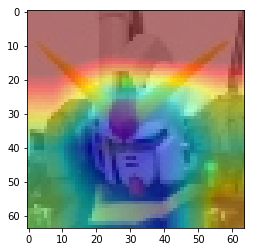

553467904/553467096 [==============================] - 36s 0us/step


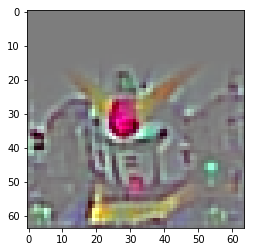

In [30]:
# テスト対象イメージを準備
preprocessed_input = np.zeros([1, height, width, color], dtype=np.int)
preprocessed_input[0] = test_img

predictions = model.predict(preprocessed_input)[0]
predicted_class = np.argmax(predictions)

# 畳み込み最終層の指定
if model_opt=="VGG16":
    cnn_out_layer = "block5_conv3"
elif model_opt=="RESNET1":
    cnn_out_layer = "add_8"
elif model_opt=="RESNET2":
    cnn_out_layer = "add_8"
else:
    cnn_out_layer = "conv2d_3"

# Grad Cam
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, cnn_out_layer)
plt.imshow(cam.astype(np.int),'gray')
plt.show()

# Guided Grad Cam
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
plt.imshow(deprocess_image(gradcam).astype(np.int),'gray')
plt.show()

### 2.2.8 モデルのファイル出力

学習させたモデルを出力し、静的学習済みモデルとして外部で活用することもできます。

ここでは、Keras形式に加えて、TensorFlowのSaved Model形式も試してみます。

In [31]:
# Keras形式でモデルを出力
output_keras_name = f"{model_dir}02_{model_opt}_{epochs}_frozen_graph.h5"
model.save(output_keras_name, include_optimizer=False)

# TensorFlow Saved Model形式でモデルを出力
from tensorflow.contrib import saved_model

out_tf_saved_model = f"{model_dir}02_{model_opt}_{epochs}_saved_models"

if os.path.exists(out_tf_saved_model):
    shutil.rmtree(out_tf_saved_model)
#saved_model_path = saved_model.save_keras_model(model, out_tf_saved_model)
saved_model_path = saved_model.save_keras_model(model, "./saved_model")


W0724 07:31:07.249290 140146061514624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 07:31:07.261420 140146061514624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 07:31:07.750354 140146061514624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

###2.2.9 TensorBoardでの確認

TensorBoardを用いてモデル構造を確認してみましょう。

Google Colabでは、直接HTTPアクセスはできないので、ngrokを用いて参照させます。

下記コード実行後し、出力されるURLにアクセスしてみましょう。

In [32]:
# Web参照のため、ngrokを利用
if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

# TensorBoardおよびngrokの起動
import subprocess
cmd = f'tensorboard --logdir="{log_dir}" --host 0.0.0.0 --port 6006 &'
proc_tb = subprocess.call(cmd, shell=True)

cmd = "./ngrok http 6006 &"
proc_ng = subprocess.call(cmd, shell=True)

# TensorBoard URL
!curl -s http://localhost:4040/api/tunnels | python -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-07-24 07:31:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.136.9, 34.232.40.183, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.136.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  6.53MB/s    in 2.0s    

2019-07-24 07:31:16 (6.53 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [0]:
# TensorBoardプロセスの停止
#!ps -ef | grep tensorboard | grep -v grep | awk '{print "kill -9",$2}'| sh

# ngrokプロセスの停止
#!ps -ef | grep ngrok | grep -v grep | awk '{print "kill -9",$2}'| sh